# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from patsy import dmatrices, dmatrix
import statsmodels.discrete.count_model as smdc

In [2]:
# set some formatting preferences to make things nicer to read
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# load in and summarize

Count data from scMPRA performmed by Shendure lab, downloaded from GEO: GSE217686

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217686

In [3]:
counts = pd.read_table('../../../data/GSE217686_assigned_oBC_CRE_mBC_joined_counts_sc_rep_mEB_series.txt')

In [4]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


- cellBC: cell barcode, 1 per cell no repeats
- rep_id: are these biological or technical replicates? Biological, but kinda both
- oBC: Tornado barcodes, circular RNA barcodes to indicate successful transfection of a given CRE into a given cell
- mBC: mRNA barcode for quantifying CRE activity 
- CRE_class: type of cis-regulatory element
- CRE_id: CRE identifier
- reads_oBC: 
- UMIs_oBC: 
- reads_mBC:
- UMIs_mBC: 

Questions/Notes to discuss with Mackenzie:
- bio vs tech reps?
- can a CRE-cell combo have more than one oBC-mBC pair? 
- can we just talk through which things can be used multiple times, which have more unique values than they are tagging and which combinations we're looking for? I think I have it all straight in my head but would be good to go through it with someone more familiar with the experimental side of things. 
- UMIs vs reads for these barcodes, the difference here is not clear to me. 
- by endogenous do they mean without inserted CREs in this case? 
- In some of Rohit's code I'm getting the sense that he's modeling the number of cells captured of each cell type is that the goal here?
- okay nevermind, I think cell type is a covariate for modeling counts per oBC 
- I can't track down this file where he got the cell type mappings from, any idea where that come from? 

In [5]:
counts.describe()

,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
count,877064.000,877064.000,877064.000,877064.000
mean,168.055,146.082,108.523,5.708
std,169.740,140.720,843.699,43.481
min,11.000,11.000,0.000,0.000
25%,61.000,55.000,0.000,0.000
50%,119.000,107.000,0.000,0.000
75%,217.000,190.000,0.000,0.000
max,5876.000,4616.000,60250.000,2890.000


In [6]:
counts.dtypes

cellBC       object
rep_id       object
oBC          object
mBC          object
CRE_class    object
CRE_id       object
reads_oBC     int64
UMIs_oBC      int64
reads_mBC     int64
UMIs_mBC      int64
dtype: object

In [7]:
counts.nunique()

cellBC       43447
rep_id           6
oBC          28938
mBC          28938
CRE_class        2
CRE_id         212
reads_oBC     2040
UMIs_oBC      1732
reads_mBC     8591
UMIs_mBC      1045
dtype: int64

In [8]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


- look into modeling/stats packages
- 

(1.0, 3034.4500000000003)

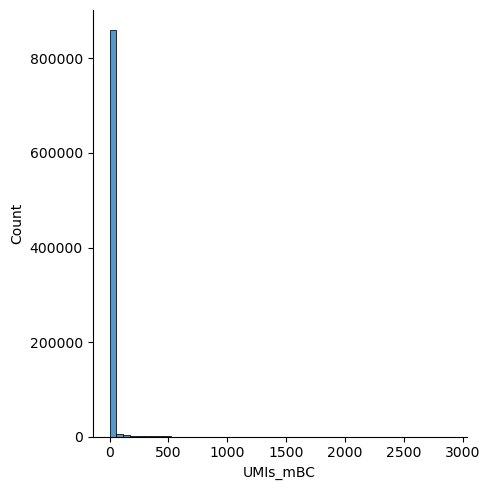

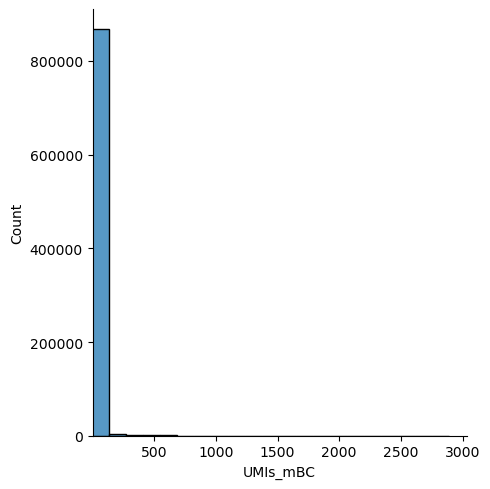

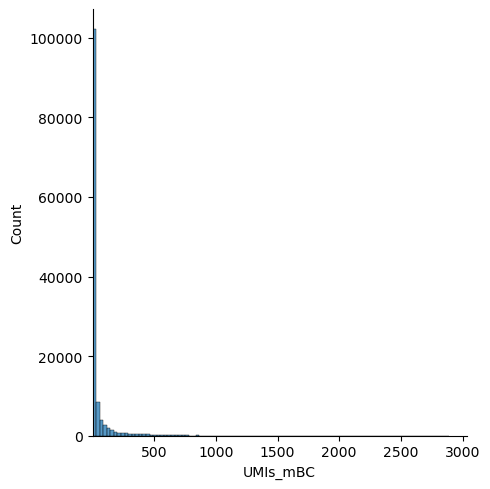

In [9]:
sns.displot(counts['UMIs_mBC'], bins = 50)

sns.displot(counts['UMIs_mBC'])
plt.xlim(1,)
sns.displot(counts['UMIs_mBC'][counts['UMIs_mBC']!=0], bins=100)
plt.xlim(1)

# Model choices

## statsmodels

GLMs: https://www.statsmodels.org/stable/glm.html

Regression with discrete dependent variable (includes zero-inflated models): https://www.statsmodels.org/stable/discretemod.html

To use this we'll probably want our scMPRA data class to have outcome/predictor attributes that can nicely go into this modeling framework (they call is endog/exog but that will just get confusing in this context). And maybe a way for the user to define what all they would like to be included in the predictor set. 

Patsy for making more complex design matrices: https://patsy.readthedocs.io/en/latest/formulas.html

In [10]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0
...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0


In [11]:
cell_type_mapping = pd.read_table('../../../data/meb_cbc_to_cell_type_mapping.txt')

In [12]:
cell_type_mapping

,orig.ident,nCount_RNA,nFeature_RNA,percent_mt,seurat_clusters,annotation
A1_AAACCCAAGATGGGCT-1,repA1,890,540,6.292,1,Neuroectoderm (brain)
A1_AAACCCAAGGATTTGA-1,repA1,2311,1245,4.457,4,Ex. Endoderm (parietal)
A1_AAACCCAGTGCCTAAT-1,repA1,4180,1766,2.608,2,Mesoderm
A1_AAACCCAGTGTTAGCT-1,repA1,4597,2100,5.895,1,Neuroectoderm (brain)
A1_AAACCCAGTTCCGCTT-1,repA1,3747,1893,5.311,1,Neuroectoderm (brain)
...,...,...,...,...,...,...
2B2_TTTGTTGGTGCATTTG-1,rep2B2,4190,1822,2.840,5,Epiblast/primitive streak
2B2_TTTGTTGGTTCGGTTA-1,rep2B2,746,543,7.641,7,Neuroectoderm (rostral)
2B2_TTTGTTGTCAGGACAG-1,rep2B2,1961,1058,6.833,3,Surface Ectoderm
2B2_TTTGTTGTCCCTCAAC-1,rep2B2,814,539,5.897,3,Surface Ectoderm


In [13]:
counts['cell_type_annotation'] = np.array(cell_type_mapping.loc[counts['cellBC']]['annotation'])

In [14]:
counts

,cellBC,rep_id,oBC,mBC,CRE_class,CRE_id,reads_oBC,UMIs_oBC,reads_mBC,UMIs_mBC,cell_type_annotation
0,A1_GTTACCCAGTTGAAGT-1,A1,GAAAGTGTATTTGGGT,ACGTAACATTATAAT,devCRE,Txndc12_chr4_7978,499,415,0,0,Surface Ectoderm
1,A1_GTTACCCAGTTGAAGT-1,A1,CCGGGGTAGGCGAAGA,AACTCAGACTACCAC,devCRE,Col1a2_chr6_72,510,414,0,0,Surface Ectoderm
2,A1_GTTACCCAGTTGAAGT-1,A1,ACTGACGTCAATCAAT,TGTTTAAGTCAACAA,devCRE,Klf4_chr4_3952,850,678,0,0,Surface Ectoderm
3,A1_GTTACCCAGTTGAAGT-1,A1,GGAGGTGTGCGCGTGG,CAACAACACATTTTA,devCRE,Foxa2_chr2_13840,549,451,0,0,Surface Ectoderm
4,A1_GTTACCCAGTTGAAGT-1,A1,CGATACCTACTTAATA,TACCTAATGGGAAAG,promoters,minP,413,353,0,0,Surface Ectoderm
...,...,...,...,...,...,...,...,...,...,...,...
877059,2B2_TTCTGTAAGGCTCTCG-1,2B2,AGCTGGTACACCCGAG,GAACAATTAAACGAG,devCRE,Sparc_chr11_7198,55,50,0,0,Neuroectoderm (rostral)
877060,2B2_TTCTGTAAGGCTCTCG-1,2B2,ATTTAGACACCAATAC,CAGCCCGCCGCCGAG,promoters,ubcP,32,31,196,11,Neuroectoderm (rostral)
877061,2B2_TGGAACTCAATCCTAG-1,2B2,GTTAGATACGCTATGG,ATGGCACATATCTTA,devCRE,Gata4_chr14_5760,21,18,0,0,Mesoderm
877062,2B2_TGGAACTCAATCCTAG-1,2B2,GATTAATTCGGTCTAC,CTCTATCGTCCTCGT,devCRE,Lamb1_chr12_2289,13,13,0,0,Mesoderm


In [15]:
x_vars = counts[['cell_type_annotation','rep_id','CRE_class','CRE_id']]
y_vars = counts['UMIs_mBC']
simple_formula = "UMIs_mBC ~ C(cell_type_annotation) + C(rep_id) + C(CRE_class) + C(CRE_id)"

In [16]:
# # regular negative binomial with simple adding of covariates
# mod_nbin = smf.negativebinomial(formula = simple_formula, data = counts).fit()

In [17]:
# creating design matrices with simple formula to try to use for ZINB, not sure how the patsy outputs go into the discrete models yet
outcome, predictors = dmatrices(simple_formula, counts)
predictors_onehot = np.asarray(predictors)

In [18]:
zinb_model = smdc.ZeroInflatedNegativeBinomialP(outcome, predictors_onehot).fit()

/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/eng26/.conda/envs/scmpra/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


         Current function value: 0.737224
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
